# PSM - Exemplo em Python

Este notebook demonstra o uso de Pareamento por Escore de Propensão (PSM), incluindo análise de balanceamento e teste de sensibilidade.

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

# Criando dataset
data = pd.DataFrame({
    'D': [1, 1, 1, 0, 0, 0],
    'Idade': [25, 30, 28, 27, 35, 24],
    'Escolaridade': [16, 18, 14, 14, 18, 16],
    'Salario': [3200, 3500, 3000, 2800, 3400, 3100]
})

## Estimando o escore de propensão com regressão logística

In [10]:
X = data[['Idade', 'Escolaridade']]
y = data['D']

model = LogisticRegression()
model.fit(X, y)
data['propensity_score'] = model.predict_proba(X)[:, 1]
data

,D,Idade,Escolaridade,Salario,propensity_score
0,1,25,16,3200,0.575854
1,1,30,18,3500,0.503560
2,1,28,14,3000,0.456195
3,0,27,14,2800,0.480249
4,0,35,18,3400,0.384882
5,0,24,16,3100,0.599264


## Separação dos grupos tratado e controle

In [11]:
treated = data[data['D'] == 1]
control = data[data['D'] == 0]

## Pareamento 1:1 com vizinho mais próximo

In [12]:
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])
matched_control = control.iloc[indices.flatten()].copy()
matched_control.index = treated.index
matched_data = pd.concat([treated, matched_control])

## Comparação dos salários após pareamento

In [13]:
matched_data.groupby('D')['Salario'].mean()

D
0    2900.000000
1    3233.333333
Name: Salario, dtype: float64

## Análise de balanceamento (Standardized Mean Differences)

In [14]:
def compute_smd(group1, group2):
    mean_diff = group1.mean() - group2.mean()
    pooled_sd = np.sqrt((group1.var() + group2.var()) / 2)
    return mean_diff / pooled_sd

print("SMD antes do pareamento:")
for var in ['Idade', 'Escolaridade']:
    print(f"{var}: {compute_smd(treated[var], control[var]):.2f}")

print("\nSMD depois do pareamento:")
for var in ['Idade', 'Escolaridade']:
    print(f"{var}: {compute_smd(treated[var], matched_control[var]):.2f}")

SMD antes do pareamento:
Idade: -0.23
Escolaridade: 0.00

SMD depois do pareamento:
Idade: 0.77
Escolaridade: 0.82


## Teste de sensibilidade: ATT com e sem pareamento

In [15]:
att_naive = treated['Salario'].mean() - control['Salario'].mean()
att_matched = matched_data.groupby('D')['Salario'].mean().diff().iloc[-1]

print(f"ATT sem pareamento: {att_naive:.2f}")
print(f"ATT com pareamento: {att_matched:.2f}")

ATT sem pareamento: 133.33
ATT com pareamento: 333.33


## Visualização dos escores de propensão

O gráfico abaixo mostra a distribuição dos escores de propensão para os grupos tratado (linha azul) e controle (linha laranja), após a estimação do modelo de escore.

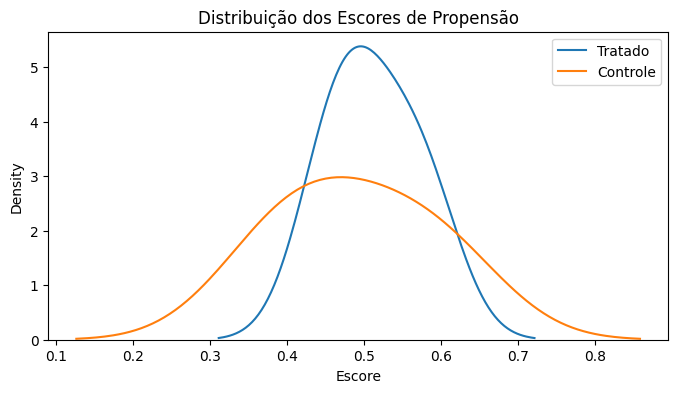

In [16]:
plt.figure(figsize=(8,4))
sns.kdeplot(data=data[data.D == 1]['propensity_score'], label='Tratado')
sns.kdeplot(data=data[data.D == 0]['propensity_score'], label='Controle')
plt.title("Distribuição dos Escores de Propensão")
plt.xlabel("Escore")
plt.legend()
plt.show()

O que o gráfico mostra:

- O eixo x representa os valores do escore de propensão, ou seja, a probabilidade estimada de receber o tratamento dado as covariáveis.

- O eixo y representa a densidade (estimativa da distribuição dos escores para cada grupo).

- A linha azul (Tratado) mostra que a maioria dos indivíduos tratados tem escores centrados perto de 0.5.

- A linha laranja (Controle) apresenta escores mais espalhados e centrados levemente à esquerda, entre 0.35 e 0.55.


Interpretação:

- Há sobreposição parcial entre os dois grupos, o que é importante para que o pareamento funcione bem.

- No entanto, o grupo controle apresenta menos unidades com escores altos (acima de 0.6), o que pode dificultar o pareamento para alguns tratados.

- Isso sugere que há overlap razoável, mas pode haver limitações em parear todos os tratados com bons controles — especialmente na cauda direita.
